In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import toml
import glob
import joblib
import h5py
from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env

In [3]:
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

In [4]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"
os.makedirs(save_dir, exist_ok=True)

In [5]:
config = toml.load("../preprocessing/config.toml")

In [6]:
npcols = ["ave_corr", "intrinsic_matrix", "distortion_coeffs"] 

In [7]:
show_categories = [
    "qd_vascular_labels",
    "qd_cell_labels", 
    "qd_beads", 
    # "qd_beads_v2",
    # "qd_vascular_labels_high_light",
]

In [8]:
base_colors = sns.color_palette("deep")
palette = {"qd_vascular_labels": base_colors[0],
           "qd_cell_labels": base_colors[1],
           "qd_beads": base_colors[2],
           "qd_beads_v2": base_colors[3]}

In [9]:
# https://stackoverflow.com/questions/22686183/calculate-the-standard-deviation-of-a-gaussian
# https://en.wikipedia.org/wiki/Variance
# from equation for variance use x^2.dot(probs) - mu^2 (mu pinned to 0 here...
def get_spread(dat, xs=None):
    py = dat.sum(axis=1)
    px = dat.sum(axis=0)
    if xs is None:
        xs = np.arange(len(px))
    py /= py.sum()
    px /= px.sum()
    stdx = np.sqrt((xs**2).dot(px) - 0) 
    stdy = np.sqrt((xs**2).dot(py) - 0)
    return stdx, stdy

In [10]:
corr_df = pd.read_parquet(os.path.join(config["dirs"]["analysis"],"fluorescence_autocorrelation.parquet"))

In [11]:
exclude_subjects = ["qd_beads_01","qd_beads_02","qd_beads_03","qd_beads_08"]

In [12]:
corr_df = corr_df.query("~subject.isin(@exclude_subjects) and days<=0")

In [13]:
for _col in npcols:
    corr_df[_col] = corr_df[_col].apply(np.vstack)

In [14]:
im_width, im_height = corr_df["ave_corr"].iat[0].shape

In [15]:
max_lag = im_width // 2
lags = np.arange(-max_lag, max_lag + 1)

In [16]:
xx, yy = np.meshgrid(np.arange(im_width), np.arange(im_height))

In [17]:
ave_matrix = np.stack(list(corr_df["intrinsic_matrix"])).mean(axis=0)
# this is really just for viz and sanity checks

In [18]:
px = ave_matrix[0,2]
py = ave_matrix[1,2]
fx = ave_matrix[0,0]
fy = ave_matrix[1,1]

In [19]:
z = 304.8 # distance to middle in mm(approximate), corresponds to 12 inches
parameters = {}
xhat = z * (xx - px) / fx
yhat = z * (yy - py) / fy
ymm_per_px = np.diff(yhat,axis=0).mean()
xmm_per_px = np.diff(xhat,axis=1).mean()
    # coords[k] = (xx - v["px"])

In [20]:
use_mm_per_px = np.mean([xmm_per_px, ymm_per_px])

In [21]:
xs = np.arange(-max_lag, max_lag + 1) * use_mm_per_px

In [22]:


spread_df = corr_df["ave_corr"].apply(get_spread).apply(pd.Series).rename(columns={0: "spread_x", 1: "spread_y"})
try:
    corr_df = corr_df.join(spread_df)
except ValueError:
    print("Skipping...")
    pass

In [23]:
# average and show spread???

In [24]:
spread_plt_df = corr_df.query("days == 0").groupby(["subject","exp_type","camera"])[["spread_x","spread_y"]].mean()
spread_plt_df = spread_plt_df.melt(ignore_index=False).reset_index()

In [25]:
# sns.set_context("paper", font_scale=.8)

In [26]:
setup_plotting_env()

In [28]:
max_display = 5.

In [29]:
im_params = {"cmap": "cubehelix", "vmin": 0, "vmax": 1}
ax_params = {"xticks": np.arange(-5., 5.1, 2.5), "yticks": np.arange(-5., 5.1, 2.5),
             "xlim": (-max_display, max_display), "ylim": (-max_display, max_display)}

In [30]:
# colorbar...

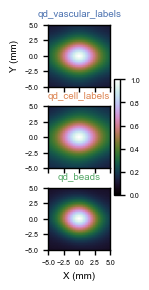

In [31]:
fig, ax = plt.subplots(
    len(show_categories),
    1,
    figsize=(1, 1 * len(show_categories)),
    sharex=True,
    sharey=True,
)
for _category, _ax in zip(show_categories, ax):
    _ave = np.stack(
        corr_df.query(f"days == 0 & exp_type == '{_category}'")["ave_corr"].to_list()
    ).mean(axis=0)
    h = _ax.imshow(
        _ave,
        **im_params,
        extent=[
            -max_lag * use_mm_per_px,
            max_lag * use_mm_per_px,
            -max_lag * use_mm_per_px,
            max_lag * use_mm_per_px,
        ],
    )
    _ax.set_title(_category, color=palette[_category])
ax[0].set_ylabel("Y (mm)")
ax[-1].set_xlabel("X (mm)")
ax[0].set(**ax_params)
fig.colorbar(h, ax=ax, shrink=.5)
fig.show()
fig.savefig(os.path.join(save_dir, f"qd_spatial_autocorr_{show_categories}.pdf"), dpi=600, bbox_inches="tight")

In [32]:
stat_df = spread_plt_df.groupby(["exp_type","variable"])["value"].agg({"mean","std"})

In [33]:
stat_dct = stat_df.to_dict()
new_stat_dct = {}
for k, v in stat_dct.items():
    new_stat_dct[k] = {}
    for k2, v2 in stat_dct[k].items():
        new_k2 = "-".join(k2)
        new_stat_dct[k][new_k2] = v2

In [34]:
with open(os.path.join(save_dir, f"stats_figure1_spatialautocorrelation.toml"), "w") as f:
    toml.dump(new_stat_dct, f)